# The K-means Algorithm in R: An Example From Communications

by Dr Graham Hesketh

This is a demonstration of how to implement the K-means algorithm in R. In this example we will use K-means to identify clusters in noisy communications signals. 

## Generating the noisy communications data

First we must generate some data. We create Nsymbs complex samples which represent data communication symbols. These symbols will be clustered in the complex plain (essentially a 2D plain with X and Y representing the real and imaginary parts of an electromagnetic field). This plot is conventionally called a constellation plot in fiber optic or wireless communications. The symbols are initially sampled from a set of $Mlevs$ distinct unperturbed locations in the complex plain before being scattered by noise in the channel as they are transmitted. Noise in communications can come from imperfect components such as amplifiers or effects such as dispersion or interchannel interference. In this example we assume the noise is Gaussian (white) noise. The two different constellations (modulation formats) we consider are QPSK with $Mlevs=4$, Fig.1 a), and Star 8QAM with $Mlevs=8$, Fig.1 b).

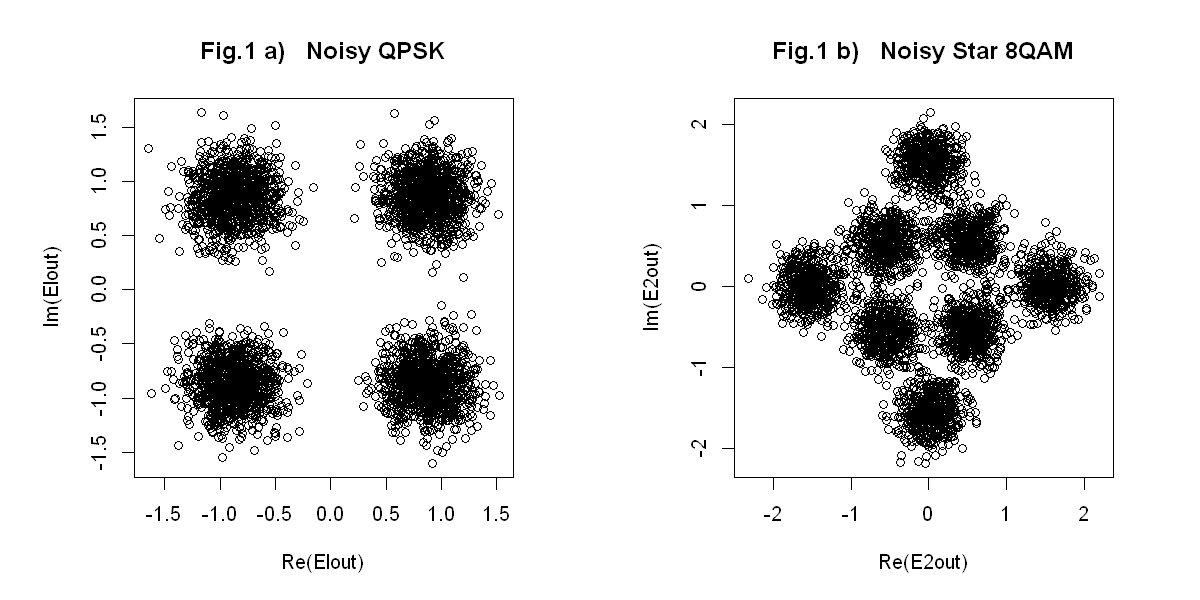

In [22]:
# First we generate the clean communication data
Nsymbs<-4000 # Number of samples we transmit
power<-1.5 # Some arbitrary power level (not really used)
Const1<-sqrt(power)/sqrt(2)*c(1+1i,-1+1i,-1-1i,1-1i) # QPSK Constellation
Const2<-sqrt(power)/sqrt(5/2)*c(1/sqrt(2)*c(1+1i,-1+1i,-1-1i,1-1i),c(2,2i,-2,-2i)) # Star 8QAM Constellation
Mlevs1<-length(Const1) # Number of unique possible data symbols to transmit
Mlevs2<-length(Const2)
symbs1<-sample(1:Mlevs1, Nsymbs, replace=T) # Integer sequences (essentialy the transmission data)
symbs2<-sample(1:Mlevs2, Nsymbs, replace=T)
E1in<-Const1[symbs1] # The modulated complex fields of the transmission data
E2in<-Const2[symbs2]
# We then add Gaussian (white) noise to represent a noisy communication channel
NoiseSD<-0.3 # Standard deviation of noise (increasing this spreads out the data leads to more missclasified data)
Noise1<-1/sqrt(2)*(rnorm(Nsymbs,mean=0,sd=NoiseSD)+1i*rnorm(Nsymbs,mean=0,sd=NoiseSD)) # Noise vectors
Noise2<-1/sqrt(2)*(rnorm(Nsymbs,mean=0,sd=NoiseSD)+1i*rnorm(Nsymbs,mean=0,sd=NoiseSD))
E1out<-E1in+Noise1 # Add the noise to the signal
E2out<-E2in+Noise2
E1out2D<-matrix(c(Re(E1out),Im(E1out)),nrow=Nsymbs,ncol=2) # Turn complex vector to 2D array for K-means algorithm
E2out2D<-matrix(c(Re(E2out),Im(E2out)),nrow=Nsymbs,ncol=2)
# Then we plot the generated noisy communications data
library(repr)
par(mfrow=c(1,2),pty="s")
options(repr.plot.width=10,repr.plot.height=5)
plot(E1out2D,main="Fig.1 a)   Noisy QPSK",xlab="Re(Elout)",ylab="Im(Elout)")
plot(E2out2D,main="Fig.1 b)   Noisy Star 8QAM",xlab="Re(E2out)",ylab="Im(E2out)")

## The K-means Algorithm

The K-means algorithm is an unsupervised learning algorithm which works as follows: 
1. Initiate K centroids as random points in your data space.
2. Assign each data point to the cluster represented by the nearest centroid by mimimum Euclidean distance.
3. Recalculate new centroids as the mean of data points in the cluster.
4. Repeat 2-3 untill no data points change cluster and the algorithm has converged. 

In R, this is carried out under the hood by a call to the kmeans function which we assign to km.out. We tell kmeans that we want Mlevs centres (clusters) and to take the best configuration of nstart different starts (because different random starts can lead to different local minima). We set the seed to ensure repeatability. The command km.out$cluster gives the cluster classification (integer) of each data point and we can then feed this code to the col (colour) argument of the plot function to plot each of the data points with a different colour depending on its assigned cluster. 

Fig.2 shows that the clustering has been succesful and the obvious clusters in each constellation are assigned different colours. We were helped by knowing a priori how many clusters to expect due to our knowledge of the modulation formats. In the next section we discuss what to do when we do not know how many clusters there may be.

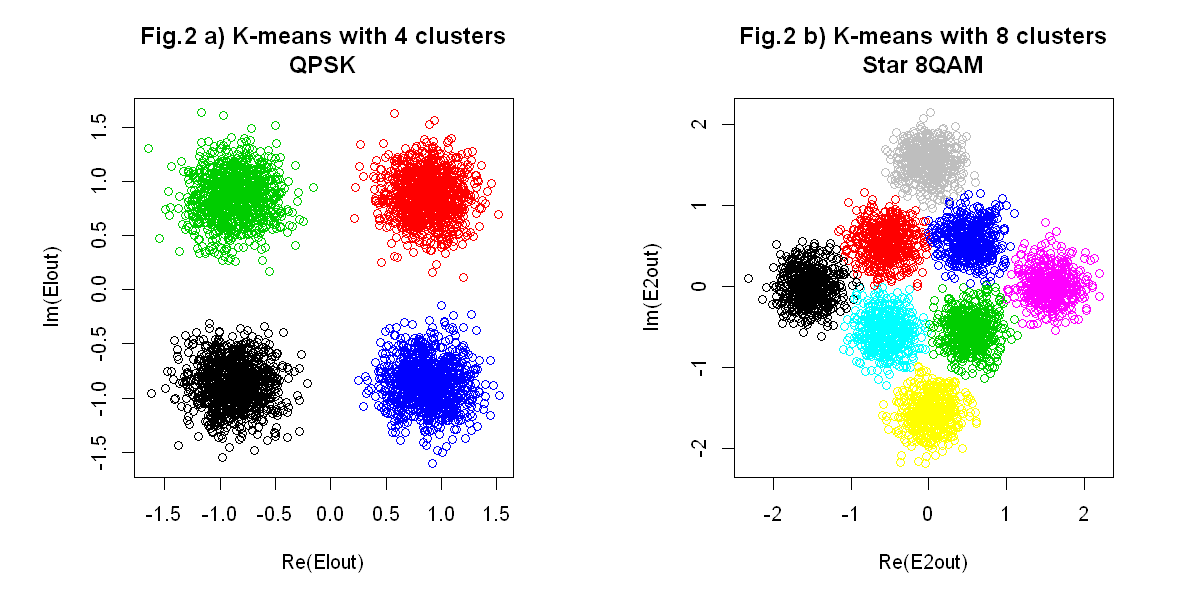

In [23]:
# Create the k-means model: km.out
set.seed(20)
km1.out=kmeans(E1out2D,centers=Mlevs1,nstart=20)
km2.out=kmeans(E2out2D,centers=Mlevs2,nstart=20)
# Scatter plot of x
par(mfrow=c(1,2),pty="s")
options(repr.plot.width=10,repr.plot.height=5)
plot(E1out2D,col=km1.out$cluster,main=paste("Fig.2 a) K-means with",Mlevs1,"clusters\nQPSK"),xlab="Re(Elout)",ylab="Im(Elout)")
plot(E2out2D,col=km2.out$cluster,main=paste("Fig.2 b) K-means with",Mlevs2,"clusters\nStar 8QAM"),xlab="Re(E2out)",ylab="Im(E2out)")

## The Elbow method for determining the number of clusters K

When we do not know how many clusters there will be, we can look for an "elbow" in the plot of the percentage of explained variance as a function of the number of clusters. The percentage of explained variance is related to the total sum of squares (km.out\$totss) and the total within cluster sum of squares (km.out\$tot.withinss) by the following formula $$\text{Percentage of explained variance}=100\left(1-\frac{\text{Total within cluster sum of squares}}{\text{Total sum of squares}}\right)=100\left(1-\frac{\sum_{j=1}^{Mlevs}\sum_{i=1}^{N_j}{\left(x_i-x_j\right)^2}}{\sum_{n=1}^{Nsymbs}\left(\mu-x_n\right)^2}\right) ,$$ where $x_i$ are the $N_j$ data points in the $j^{th}$ cluster, $x_j$ are the $Mlevs$ cluster centroids, $x_n$ are all the $Nsymbs$ data points and $\mu$ is their mean. The elbow appears as a kink in the curve at which point increasing the number of clusters offers little gain in the explained variance. Fig.3 a) and Fig.3 b) show that there are kinks in the percentage of explained variance when the number of clusters equals 4 and 8, respectively, as we would expect. At these points we are explaining roughly 95% of the variance. Note though, that the elbow will not always be so pronounced when clustering is not as obvious and thus the elbow method can be somewhat subjective.

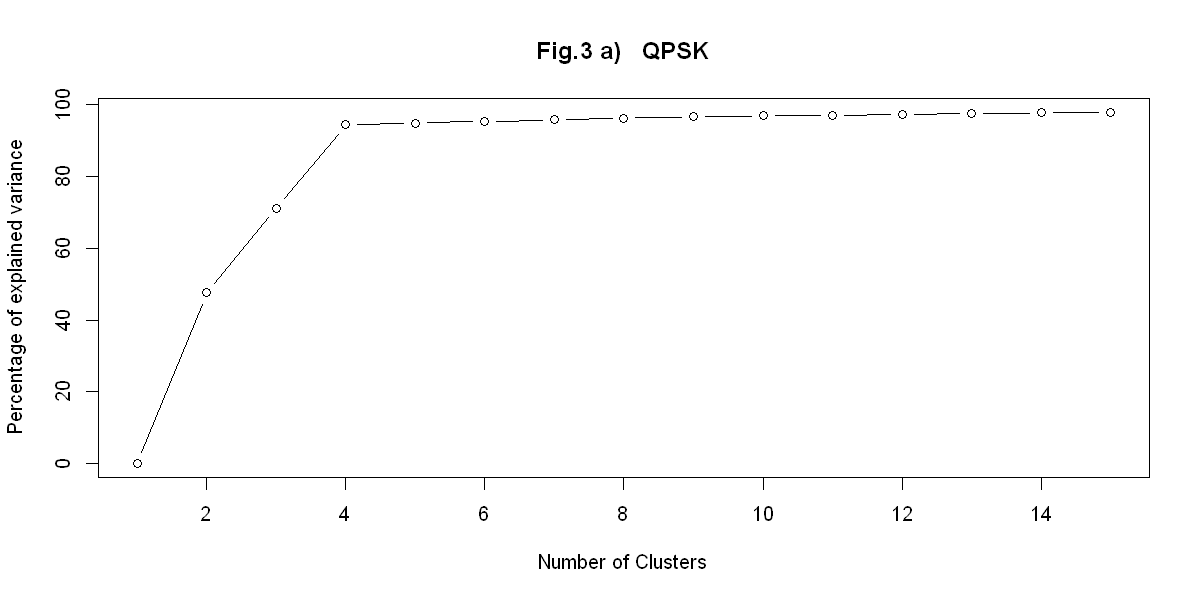

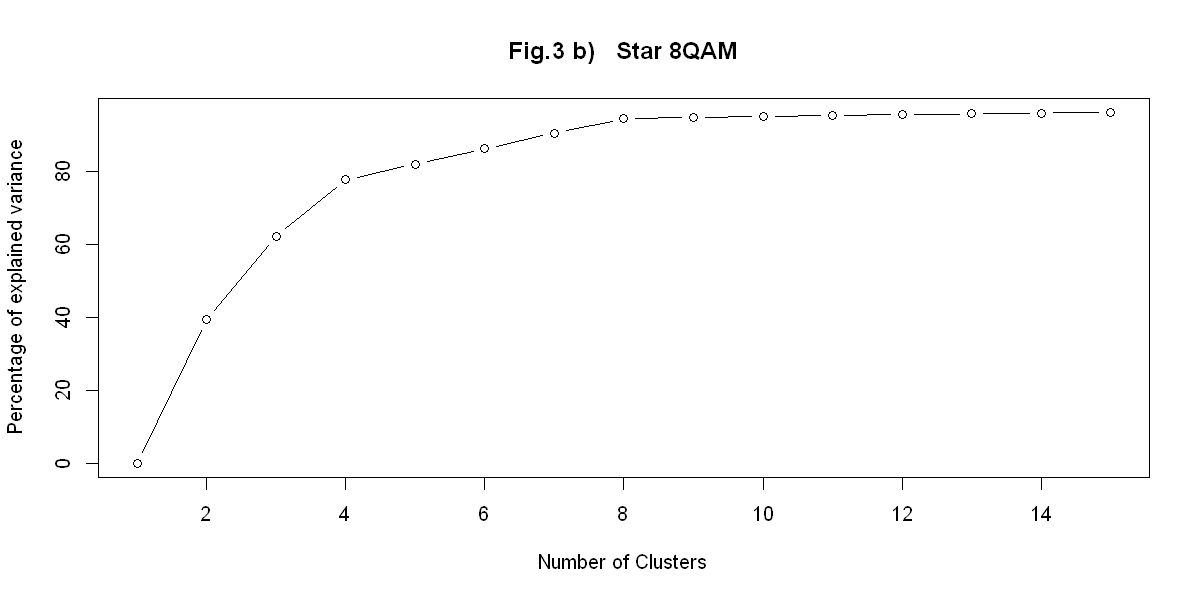

In [24]:
# Initialize percentage of explained variance: pev
pev1 <- 0
pev2 <- 0
# Calculate wsss for 1 to 15 cluster centers
for (i in 1:15) {
  km1.out=kmeans(E1out2D,centers=i,nstart=20)
  km2.out=kmeans(E2out2D,centers=i,nstart=20)
  pev1[i] <- 100*(1-(km1.out$tot.withinss)/(km1.out$totss))
  pev2[i] <- 100*(1-(km2.out$tot.withinss)/(km2.out$totss)) 
}
# Plot percentage of explained variance vs. number of clusters
plot(1:15, pev1, type = "b",main=paste("Fig.3 a)   QPSK"),
     xlab = "Number of Clusters", ylab = "Percentage of explained variance")
plot(1:15, pev2, type = "b",main=paste("Fig.3 b)   Star 8QAM"),
     xlab = "Number of Clusters", ylab = "Percentage of explained variance")

## Communications statistics

In communications we are often interested in quantifying the rate at which symbols are classified erroneously. We can estimate this rate using the kmeans function in R. As the kmeans clusters names (integers) are labelled randomly, first we need to find a code to translate the kmeans cluster labels into the integers we initially used to label the constellation positions. This can be done using the minimal distance of each centroid to the original constellation points. We can then count the fraction of data symbols that are erroneously classified by the clustering at the output by comparing them to their knwon input values (in a real transmission we would not always know the true values at the output but we could use known training data to assess signal quality). It is sometimes convenient to express the symbol error rate in log to the base 10, if that value is -Inf the transmission is error free but we typically want that number to be less than -3 (this is to ensure signal quality is good enough to enable forward error correction (FEC) codes but that is beyond our current scope). Below, we see that the QPSK signal is error free but the Star 8QAM transmission is not good enough.

In [25]:
set.seed(20)
km1.out=kmeans(E1out2D,centers=Mlevs1,nstart=20)
km2.out=kmeans(E2out2D,centers=Mlevs2,nstart=20)

CodeKey1<-rep(NA,Mlevs1)
for (i in 1:Mlevs1) {
    CodeKey1[i]<-which.min(abs(km1.out$centers[i,1]+1i*km1.out$centers[i,2]-Const1)**2)
}
CodeKey2<-rep(NA,Mlevs2)
for (i in 1:Mlevs2) {
    CodeKey2[i]<-which.min(abs(km2.out$centers[i,1]+1i*km2.out$centers[i,2]-Const2)**2)
}
symb_errs1<-sum(CodeKey1[km1.out$cluster]!=symbs1)
symb_err_rate1<-log10(symb_errs1/Nsymbs)
sprintf('log10( QPSK Symbol error rate ) = %f',symb_err_rate1)
symb_errs2<-sum(CodeKey2[km2.out$cluster]!=symbs2)
symb_err_rate2<-log10(symb_errs2/Nsymbs)
sprintf('log10( Star8QAM Symbol error rate ) = %f',symb_err_rate2)

[1] "log10( QPSK Symbol error rate ) = -Inf"

[1] "log10( Star8QAM Symbol error rate ) = -1.838632"

Another statistic we are often interested in in communications is the error vector magnitude which is a measure of the typical vectorial difference between the received data point and its true correct unperturbed position. That is, it is a measure of the noise. This can be approximately related to the within cluster sum of squares using the following formula (equality holds in the absence of cluster missclassification) $$\text{EVM}=\sqrt{\frac{1}{Nsymbs-1}\sum_{n=1}^{Nsymbs}\left(x_{n}^{Received}-x_{n}^{True}\right)^2}\approx \sqrt{\frac{1}{Nsymbs-1}\sum_{j=1}^{Mlevs}\sum_{i=1}^{N_j}{\left(x_{i}^{Received}-x_{j}^{True}\right)^2}} .$$ Where $x^{Received}_{i}$ are the $N_{j}$ points assigned to the $j^{th}$ cluster with centroid $x^{True}_j$ . Obviously, the square root expression on the left is just the standard deviation of our Gaussian noise at the input and so we can use this expression as a check on our code by confirming the square root expression on the right, which we can get from the $\text{tot.withinss}$ attribute of the K-means algorithm, is approximately equivalent to the value of our $NoiseSD$ variable at the start which in this case it is.

In [29]:
sprintf('EVM of QPSK ~ %f',sqrt(km1.out$tot.withinss/(Nsymbs-1)))
sprintf('EVM of Star8QAM ~ %f',sqrt(km2.out$tot.withinss/(Nsymbs-1)))

[1] "EVM of QPSK ~ 0.297895"

[1] "EVM of Star8QAM ~ 0.299295"